![logo](../../picture/license_header_logo.png)
> **Copyright &copy; 2020 - 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). <br>
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# 02 - MA is not Martial Arts

Authored by: [Kian Yang Lee](https://github.com/KianYang-Lee) - kianyang.lee@certifai.ai


## Notebook Description

This tutorial will showcase how to apply **moving average (MA)** model. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Understand the fundamentals of MA model
2. Understand and apply autocorrelation function (ACF)
3. Build and apply MA model by choosing suitable parameters

## Notebook Outline
Below is the outline for this tutorial:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Basic Analytics and Autocorrelation Function (ACF)](#analytics)<br>
4. [Moving Average (MA) Model](#ma)<br>
    a. [MA(2) Process](#ma-2)<br>
    b. [MA(3) Process](#ma-3)<br>
5. [Exercise](#exercise)
6. [Reference](#reference)
7. [Bonus](#bonus)

## <a name="configuration">Notebook Configurations</a>
Following are the modules that will be used for this tutorial. 

In [1]:
%matplotlib inline

import sys
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## <a name="dataset">Dataset</a>
The dataset to be used for this tutorial will be generated randomly.

In [2]:
# reproducibility
np.random.seed(38)

# time component
time_steps = np.arange(100)

# moving average data
noise = np.random.normal(loc=0, scale=6.5, size=len(time_steps))
trend = time_steps * 2.75
seasonality = 10 + np.sin(time_steps * 0.25) * 20
generated_data = trend + seasonality + noise

## <a name="analytics">Basic Analytics and Autocorrelation Function (ACF)</a>
Visualization is a great way to understand the data at our disposal. We will plot a time plot and package it into a function to save the trouble of writing repetitive codes.

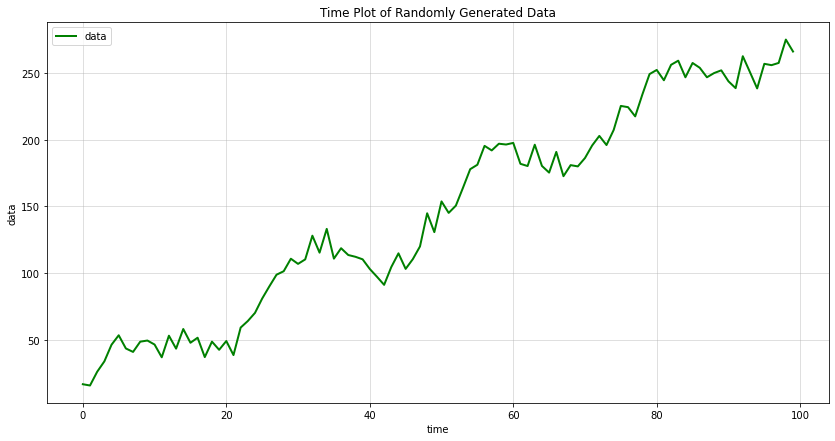

In [3]:
# generate time plot
def generate_time_plot(x1, y1, x2=None, y2=None, overlay=False, title="Time Plot", label2=None, xlabel="time", ylabel="data"):
    """
    Display a time plot of x1 versus y1 with the respective x-axis and y-axis labels.
    If overlay is True, x2 and y2 arguments need to be supplied to plot an overlay time plot.
    """
    plt.figure(figsize=(14,7))
    plt.plot(x1, y1, 'k-', label="data", color='green', linewidth=2)
    if overlay:
        plt.plot(x2, y2, 'b-', label=label2, color='red', linewidth=2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.5)
    plt.legend();
    
generate_time_plot(time_steps, generated_data, title="Time Plot of Randomly Generated Data")

We can also perform moving average smoothing to smoothen the plot. It is often used to smoothen the data by specifiying the window size. Generally, each moving average value will be the average of the points in the "moving window".

For this case, we will be using a window size of 5, 15 and 25 to show the effects of window size on smoothness of plot. In order to make use of the `rolling` method in `pandas`, we first need to convert our data into `pandas Series`. Also, we will start with using a window size of 3.

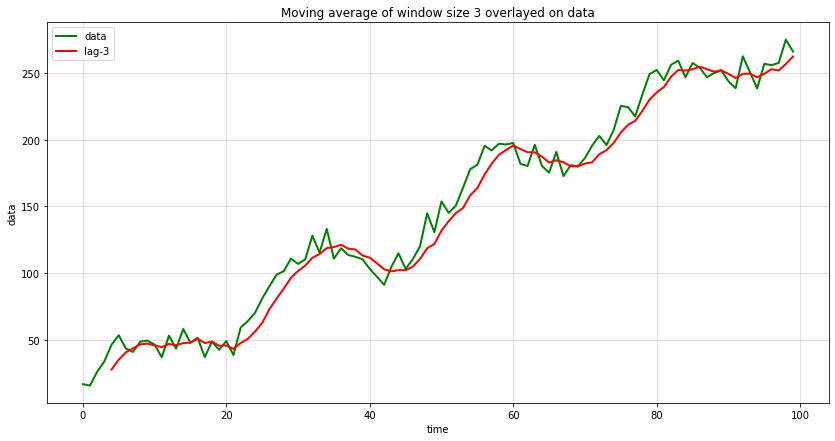

In [4]:
series_data = pd.Series(generated_data)

# case with lag of 3
series_lag_3 = series_data.rolling(window=5).mean()
generate_time_plot(time_steps, generated_data, time_steps, series_lag_3, overlay=True, 
                   title="Moving average of window size 3 overlayed on data", label2="lag-3")

Let's try using a window size of 15. Notice that the the shape of line.

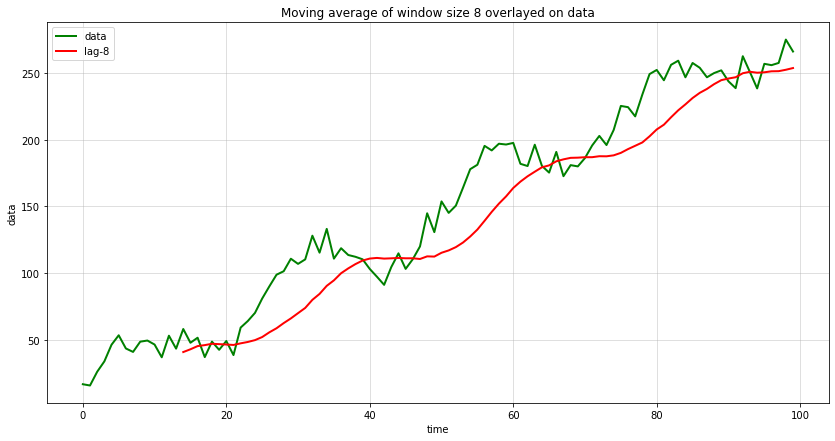

In [5]:
# case with lag of 8
series_lag_8 = series_data.rolling(window=15).mean()
generate_time_plot(time_steps, generated_data, time_steps, series_lag_8, overlay=True, 
                   title="Moving average of window size 8 overlayed on data", label2="lag-8")

Finally, try with a window size of 13. The line should lose most of its curviness at this time.

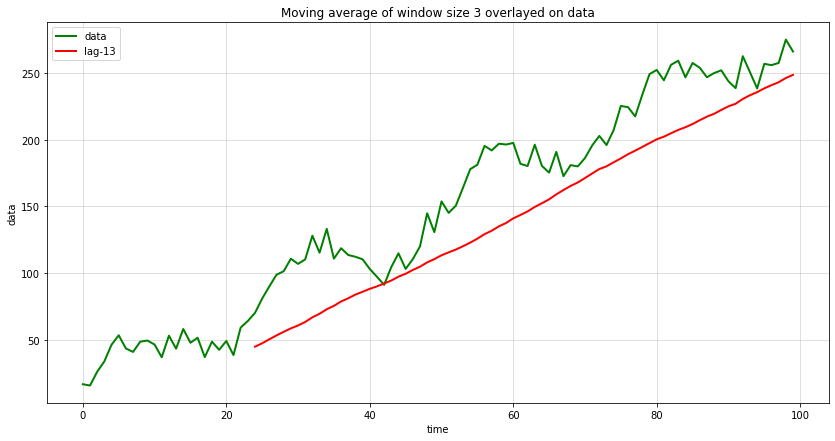

In [6]:
# case with lag of 13
series_lag_13 = series_data.rolling(window=25).mean()
generate_time_plot(time_steps, generated_data, time_steps, series_lag_13, overlay=True, 
                   title="Moving average of window size 3 overlayed on data", label2="lag-13")

We see that as the window size gets larger, the moving average becomes more and more smooth, at the expense of becoming less responsive to the fluctuations of the data. 

It is important to differentiate the difference between moving average smoothing (what we had just done) and moving average (MA) model. The difference lies in that moving average smoothing is more commonly used to estimate trend and seasonality of past data, while MA model is used to forecast future data by regressing on past forecast errors.

### Autocorrelation Function (ACF)
Autocorrelation function (ACF) plot can be generated using `statsmodels` API in one simple line.

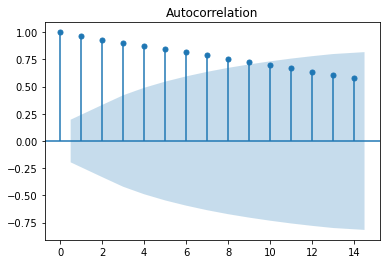

In [7]:
plot_acf(generated_data, lags=range(0,15), alpha=0.05);

There are a few things to note when one attempts to interpret this plot, which is listed as below:

1. **Blue region** -> confidence interval which can be set by varying the parameter of alpha. In this plot it is set to 0.05, meaning 95% confidence interval.
2. **Stems/Bars** -> lagged-correlation values. In this case, the lag-1 bar is highly correlates with the current endogenous values, and the correlations of other lagged values decrease as the number of lag increases. This is an indication of a non-stationary time series.
3. **Stems/Bars outside of blue region** -> correlations that are statistically significant. The number of bars that lie outside the blue region are considered as an indication to choosing *q* order in the moving average (MA) model. 
4. **Pattern of stems/bars** -> If the correlations of other lagged values decrease *gradually* as the number of lag increases, it is an indication of a non-stationary time series (which is the case here). On the other hand, if the correlations of other lagged values decrease *abruptly* as the number of lag increases, it is an indication of a stationary time series.

Although we already know in advance that this data is non-stationary as we included trend and seasonality in the data, we can check for seasonality using Augmented Dickey-Fuller (ADF) test, and apply differencing to transform the data.

In [8]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
    

result = adfuller(generated_data)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -0.628561
P-Value                  0.864397
# Lags Used             11.000000
# Observations Used     88.000000
Critical Value (1%)     -3.506944
Critical Value (5%)     -2.894990
Critical Value (10%)    -2.584615
dtype: float64


A high p-value means that there is a high possibility that non-stationarity is due to chance, and we will reject the assumption that it is stationary. This confirms our assumptions. We can apply differencing method to transform the non-stationary time series into a stationary one.

In [9]:
diff_1_data = generated_data[:-1] - generated_data[1:]
print_adf_result(adfuller(diff_1_data))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -4.109416
P-Value                  0.000934
# Lags Used             10.000000
# Observations Used     88.000000
Critical Value (1%)     -3.506944
Critical Value (5%)     -2.894990
Critical Value (10%)    -2.584615
dtype: float64


Since p-value is lesser than 0.05, we are quite sure that the time series' stationarity is not due to random chance. The alternate hypothesis of non-stationarity for tested time series is accepted. We can inspect the time plot of a non-stationary time series. 

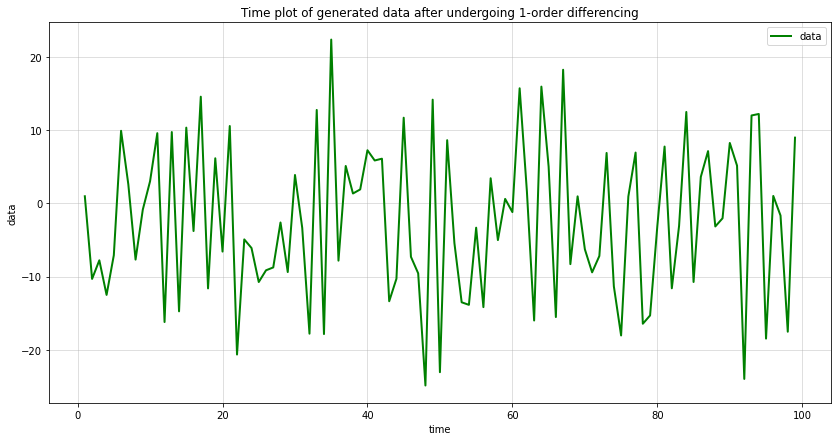

In [10]:
generate_time_plot(time_steps[1:], diff_1_data, time_steps, 
                   title="Time plot of generated data after undergoing 1-order differencing")

Let's generate a ACF for the differenced data.

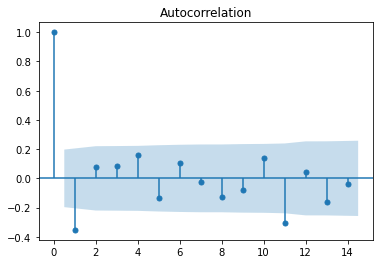

In [11]:
plot_acf(diff_1_data, lags=range(0,15), alpha=0.05);

The ACF plot above shows that there are two bars, bar 1 and bar 11, that have significant correlation values. This indicates that the suitable q-order for the model is AR(1) and AR(11).

## <a name="ma">Moving Average (MA) Model</a>
After performing some basic analytics on the dataset at hand, it's time to turn our attention to MA.

The general formula for MA model is as below: 


<div style="text-align: center;">$y_t=e_t+θ_1e_{t−1}+θ_2e_{t−2}+⋯+θ_qe_{t−q}$</div>

where $e_t$ is white noise, $e_{t-1}$, $e_{t-2}$ up until $e_{t-q}$ are past forecast errors, and $\theta$'s are coefficients

Generally, fitting MA models requires iterative procedures to test for the best q-order. Nonetheless, we can leverage on `statsmodels` to build a MA model easily. We will be using `statsmodels` module extensively for building MA model. You can read more about the module [here](https://www.statsmodels.org/).

MA(1)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   99
Model:                     ARMA(0, 1)   Log Likelihood                -368.729
Method:                       css-mle   S.D. of innovations             10.025
Date:                Fri, 26 Mar 2021   AIC                            743.457
Time:                        16:55:38   BIC                            751.243
Sample:                             0   HQIC                           746.607
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5454      0.706     -3.605      0.000      -3.929      -1.162
ma.L1.y       -0.3023      0.079     -3.847      0.000      -0.456      -0.148
                                    Roots     

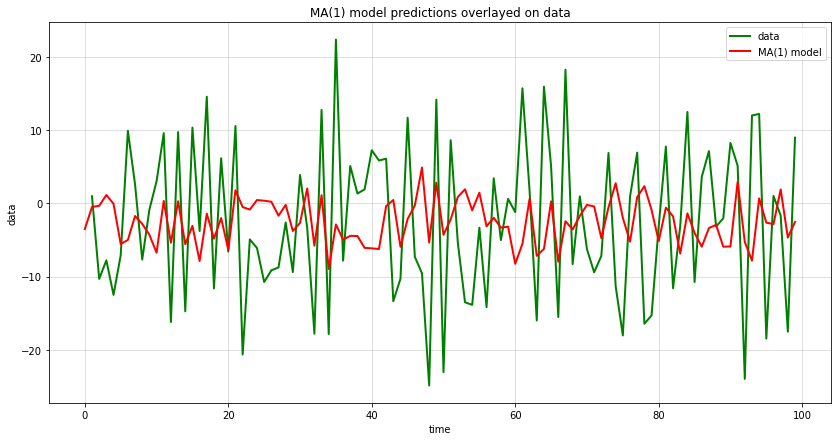

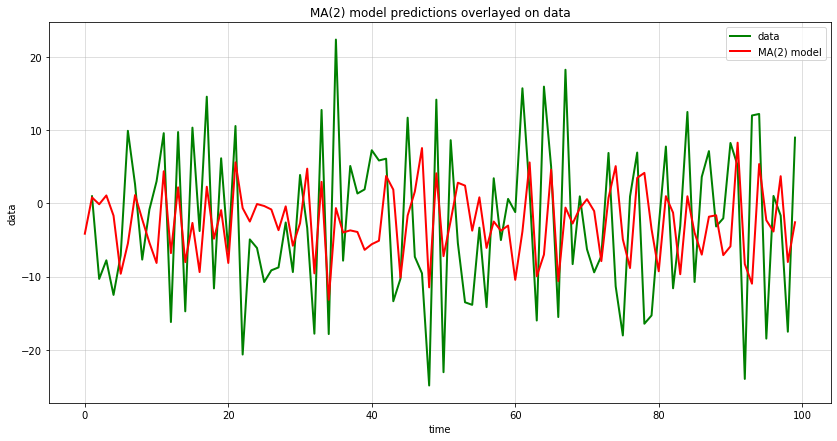

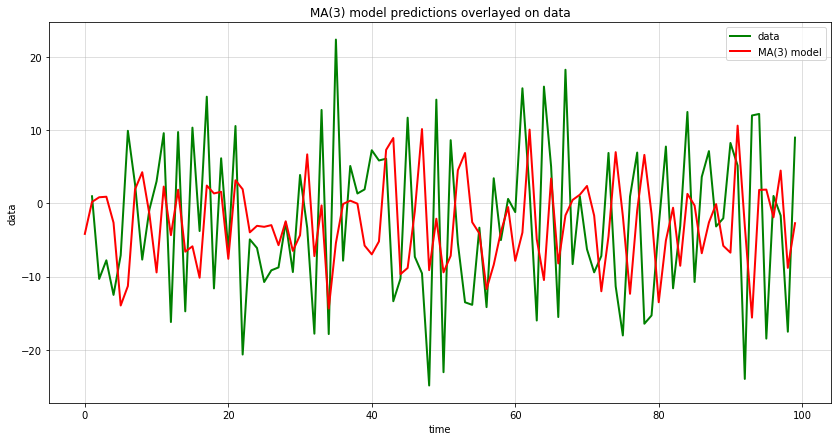

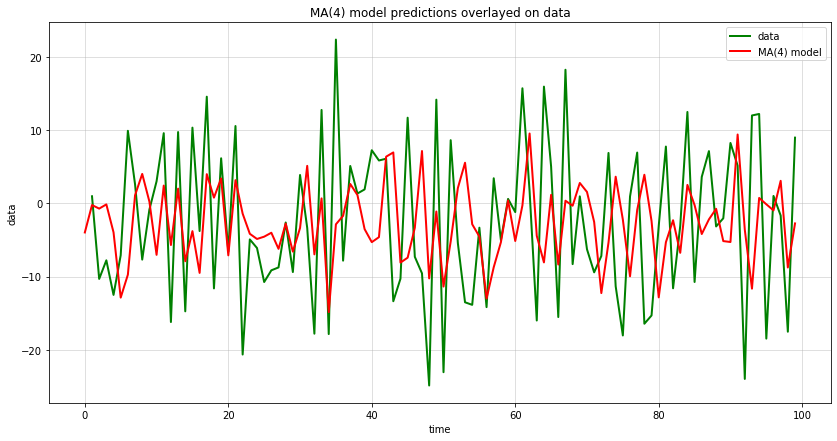

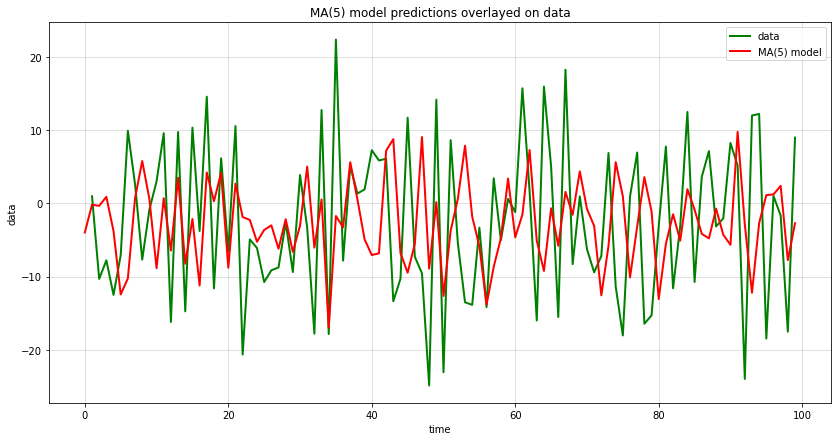

In [12]:
# plot different orders (q's)  
for q in range(1,6):
    model = ARMA(diff_1_data, (0,q)).fit()
    generate_time_plot(time_steps[1:], diff_1_data, time_steps, model.predict(start=1, end=100), overlay=True, 
                   title=f"MA({q}) model predictions overlayed on data", label2=f"MA({q}) model")
    print(f"MA({q})")
    print(model.summary())
    print("\n\n")

Even though it seems that MA(5) fits most closely with the data, there is this issue of overfitting which cause it to be not the best parameter for the model. Based on the ACF plot in previous section, we see that only lag-1 value has a significant correlation with the current value. This suggests that a suitable q-order could be 1 instead.

### <a name="ma-2">MA(2) Process</a>
A MA process with q-order of 2 has the following formula:
<div style="text-align: center;">$y_t=e_t+\theta_1e_{t−1}+\theta_2e_{t−2}$</div>

where $e_t$ is white noise, $e_{t-1}$ and $e_{t-2}$ are past forecast errors, and $\theta$'s are coefficients.

In [13]:
# simulate MA(2) process
np.random.seed(38)
maparams = np.array([.75, -.55])
ma_2 = np.r_[1, maparams]
simulated_ma_2 = ArmaProcess(ma=ma_2).generate_sample(nsample=100)

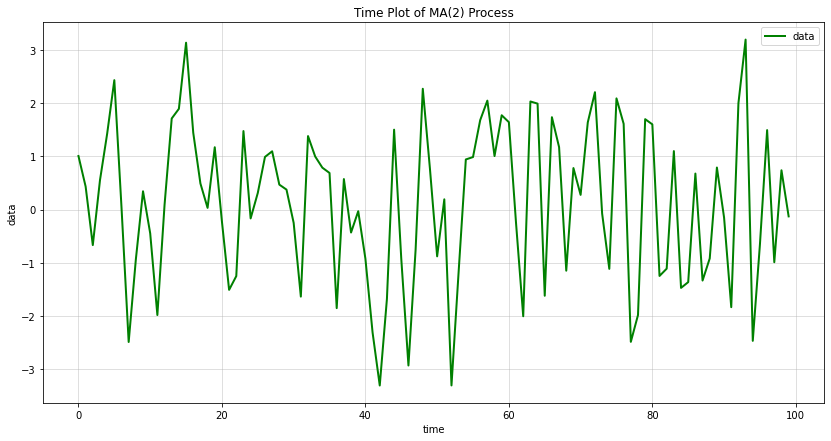

In [14]:
# plot time plot for MA(2) process
generate_time_plot(time_steps, simulated_ma_2, title="Time Plot of MA(2) Process")

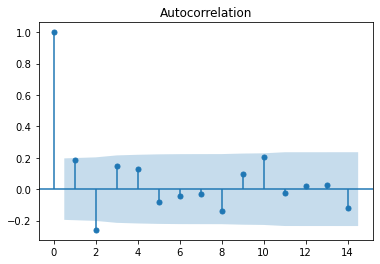

In [15]:
# plot ACF for MA(2) process
plot_acf(simulated_ma_2, lags=range(0,15), alpha=0.05);

### <a name="ma-3">MA(3) Process</a>
A MA process with q-order of 3 has the following formula:
<div style="text-align: center;">$y_t=e_t+\theta_1e_{t−1}+\theta_2e_{t−2}+\theta_3e_{t−3}$</div>

where $e_t$ is white noise, $e_{t-1}$, $e_{t-2}$ and $e_{t-3}$ are past forecast errors, and $\theta$'s are coefficients.

In [16]:
# simulate MA(3) process
np.random.seed(38)
maparams = np.array([.95, .65, .45])
ma_3 = np.r_[1, maparams]
simulated_ma_3 = ArmaProcess(ma=ma_3).generate_sample(nsample=100)

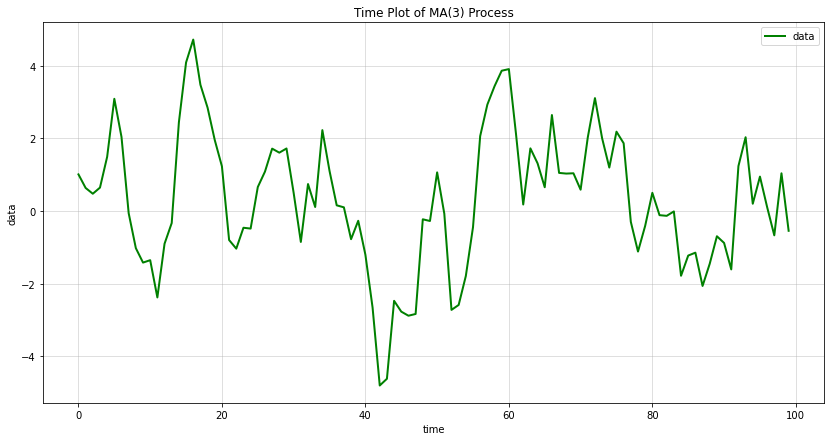

In [17]:
# plot time plot for MA(3) process
generate_time_plot(time_steps, simulated_ma_3, title="Time Plot of MA(3) Process")

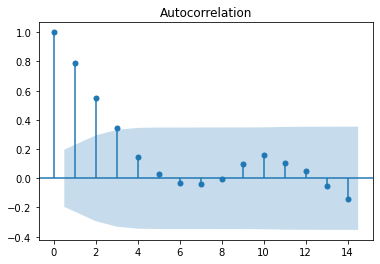

In [18]:
# plot ACF for MA(3) process
plot_acf(simulated_ma_3, lags=range(0,15), alpha=0.05);

## <a name="exercise">Exercise</a>

This exercise section is attached for you to practice and hone your skills. Try your best effort to complete it without referring to the solution.

### Notebook Configurations
**INSTRUCTIONS**: You can import any module that you wish to use for this exercise. However, if you run the cells from the start of this notebook, most probably all the modules which you need had already been imported at this point.

In [19]:
# import modules
### BEGIN SOLUTION


### END SOLUTION

### Dataset
**INSTRUCTIONS**: Please load the dataset into the environment using the path specified for you.

In [20]:
# specified path
dataset_path = Path().resolve().parent.parent/"datasets/others"
filename = "furniture-sales.csv"

In [21]:
# import dataset using specified path and filename above
### BEGIN SOLUTION

### END SOLUTION

### Basic Analytics and ACF
**INSTRUCTIONS**: Perform some basic analytics on the dataset by following the guidelines that are provided in each cell.

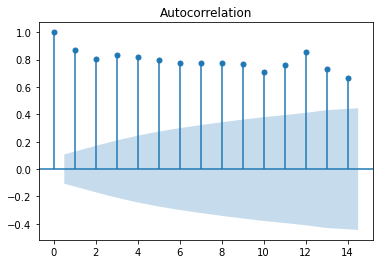

In [22]:
# generate ACF plot
### BEGIN SOLUTION

### END SOLUTION

In [23]:
# perform transformation for stationarity
### BEGIN SOLUTION

### END SOLUTION

#check for stationarity post-transformation
### BEGIN SOLUTION

### END SOLUTION

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.875214
P-Value                   0.048307
# Lags Used              17.000000
# Observations Used     317.000000
Critical Value (1%)      -3.451148
Critical Value (5%)      -2.870701
Critical Value (10%)     -2.571651
dtype: float64


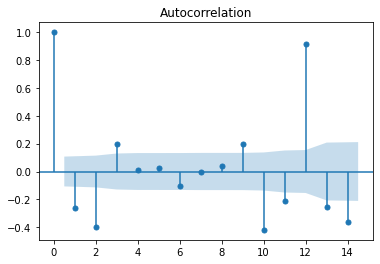

In [24]:
# generate ACF plot 
### BEGIN SOLUTION

### END SOLUTION

### MA Model
**INSTRUCTIONS**: Fit MA model using the provided data.

MA(1)
                              ARMA Model Results                              
Dep. Variable:           MRTSSM442USN   No. Observations:                  335
Model:                     ARMA(0, 1)   Log Likelihood               -2659.562
Method:                       css-mle   S.D. of innovations            677.580
Date:                Fri, 26 Mar 2021   AIC                           5325.124
Time:                        16:55:42   BIC                           5336.566
Sample:                             0   HQIC                          5329.685
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 18.4410      7.498      2.459      0.014       3.745      33.137
ma.L1.MRTSSM442USN    -0.8000      0.031    -26.177      0.000      -0.860      -0.740
              

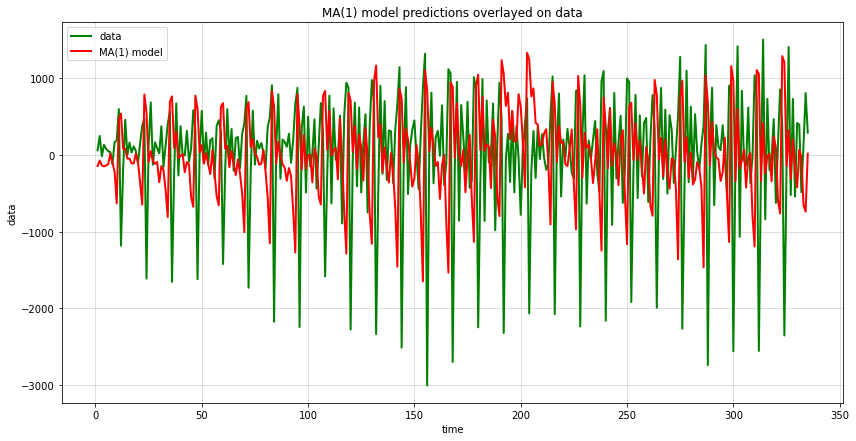

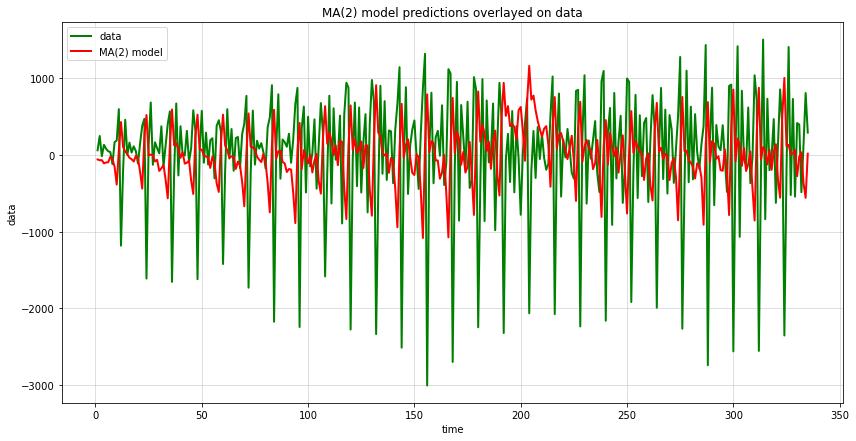

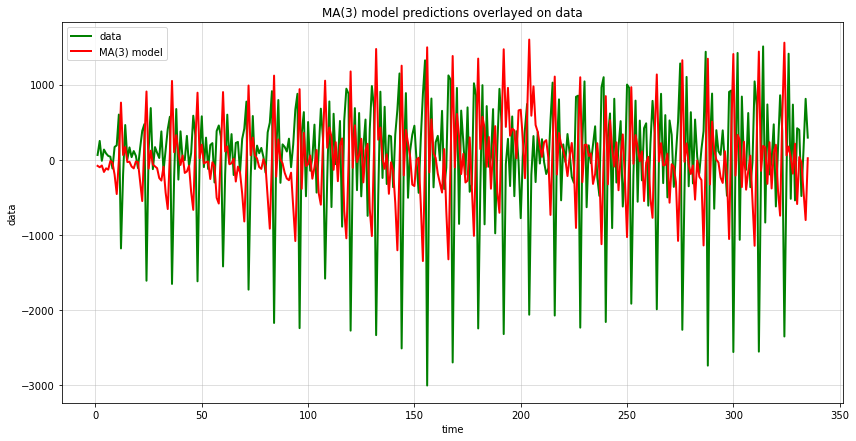

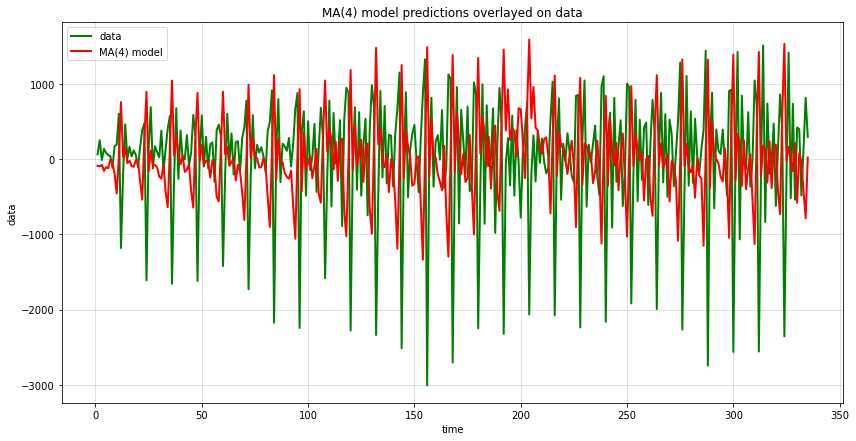

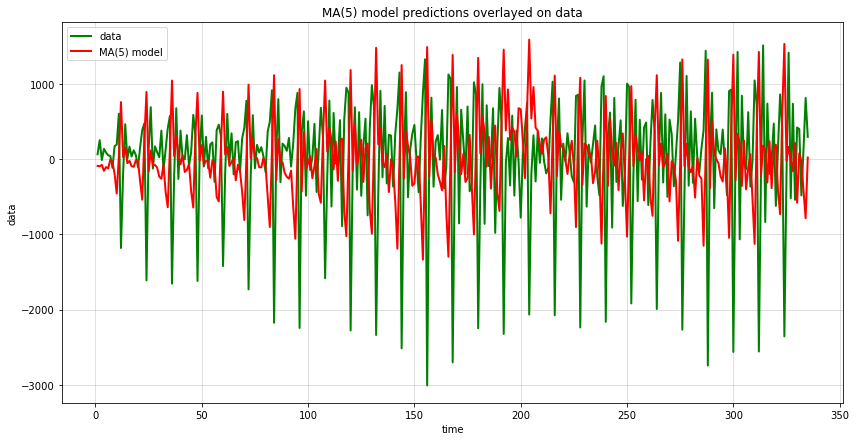

In [25]:
# build MA model by iterating through a list of q-order parameters
### BEGIN SOLUTION







### END SOLUTION

## <a name="reference">Reference</a>
1. [Statsmodels](www.statsmodels.org)
2. [Time Series Forecasting with Autoregressive Processes](https://towardsdatascience.com/time-series-forecasting-with-autoregressive-processes-ba629717401)

## <a name="bonus">Bonus</a>
An intuitive way to memorize whether should we use PACF or ACF to check for suitable order parameters for AR and MA is by remembering **p**-order needs **PACF** to verify the parameter.